In [2]:
import os
from glob import glob
import random
import torch
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torchvision.utils import make_grid
from matplotlib import pyplot as plt
import itertools
import numpy as np
from PIL import Image
from sklearn.manifold import TSNE 

from hyperbox_app.feature_shift.bnnas import BNNet
from hyperbox_app.feature_shift.twonn import estimate_id
from hyperbox.networks.nasbench201 import NASBench201Network
from hyperbox.datamodules import CIFAR10DataModule

In [3]:

def load_state_dict(net, ckptfile):
    ckpt = torch.load(ckptfile, map_location='cpu')
    weights = {}
    for key, value in ckpt['state_dict'].items():
        if 'network' in key:
            weights[key.replace('network.', '')] = value
    net.load_state_dict(weights)

In [4]:

device = 'cuda' if torch.cuda.is_available() else 'cpu'
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

testset = torchvision.datasets.CIFAR10(
    root='~/datasets/cifar10', train=False, download=False, transform=transform_test)
testloader = torch.utils.data.DataLoader(
    testset, batch_size=512, shuffle=True, num_workers=4)

for batch_idx, (imgs, labels) in enumerate(testloader):
    if batch_idx==2:
        imgs = imgs.to(device)
        labels = labels.to(device)
        print(labels)
        batch_size = imgs.shape[0]
        break


tensor([3, 5, 3, 5, 3, 5, 3, 2, 8, 0, 2, 4, 2, 3, 0, 6, 4, 7, 9, 9, 3, 9, 7, 4,
        9, 7, 1, 8, 2, 6, 1, 3, 0, 2, 3, 1, 3, 2, 0, 9, 5, 7, 7, 0, 5, 5, 3, 4,
        2, 0, 4, 0, 6, 7, 5, 8, 1, 5, 9, 3, 9, 3, 9, 3, 3, 8, 8, 6, 1, 1, 8, 2,
        4, 1, 3, 7, 7, 4, 1, 0, 5, 1, 5, 3, 6, 3, 2, 4, 2, 9, 7, 2, 4, 1, 9, 7,
        7, 1, 4, 7, 6, 5, 8, 0, 5, 9, 8, 4, 1, 6, 7, 6, 6, 2, 0, 7, 1, 2, 3, 1,
        8, 0, 3, 4, 6, 4, 7, 2, 5, 1, 3, 4, 5, 7, 0, 7, 7, 0, 4, 8, 0, 3, 6, 5,
        6, 9, 1, 3, 4, 1, 8, 3, 5, 4, 3, 5, 0, 5, 0, 6, 4, 4, 9, 3, 0, 0, 1, 4,
        9, 7, 5, 3, 7, 4, 4, 8, 3, 1, 6, 6, 2, 8, 9, 9, 4, 2, 9, 1, 6, 5, 9, 6,
        7, 3, 2, 1, 3, 9, 0, 9, 2, 1, 0, 8, 0, 7, 9, 0, 6, 3, 1, 8, 8, 2, 5, 6,
        5, 5, 3, 2, 3, 4, 7, 8, 4, 2, 0, 2, 6, 2, 4, 3, 2, 7, 1, 3, 3, 4, 7, 7,
        8, 2, 8, 7, 5, 5, 0, 5, 9, 3, 8, 2, 6, 8, 6, 6, 8, 4, 1, 1, 9, 1, 2, 3,
        0, 1, 9, 6, 0, 8, 5, 5, 6, 6, 8, 8, 1, 9, 1, 1, 8, 6, 5, 3, 1, 9, 3, 5,
        1, 1, 2, 1, 2, 5, 6, 2, 7, 5, 6,

In [19]:

# masks = glob('/home/xihe/xinhe/hyperbox/logs/runs/bnnas/bnnas_random/*.json')[:10]
# ckpts = glob('/home/xihe/xinhe/hyperbox/logs/runs/bnnas_c10_random_nodepth/*/*/checkpoints/*/*.ckpt')
masks = glob('/home/xihe/xinhe/hyperbox/logs/runs/bnnas_c10_all20_bn20/bnnas_c10_all20_bn20_search/2021-10-27_05-33-45/pareto_json/*.json')[:10]
ckpts = glob('/home/xihe/xinhe/hyperbox/logs/runs/bnnas_c10_all20_bn20/*_nodepth_finetune*/*/checkpoints/*/*.ckpt')
# masks = glob('/home/xihe/xinhe/hyperbox/logs/runs/nasbench201_finetune/masks/nasbench201_mask_*.json')
# ckpts = glob('/home/xihe/xinhe/hyperbox/logs/runs/nasbench201_finetune/nasbench201_finetune*/*/checkpoints/*/*.ckpt')
ckpts = sorted(ckpts)
masks = sorted(masks)
ckpts[:2], masks[:2]

(['/home/xihe/xinhe/hyperbox/logs/runs/bnnas_c10_all20_bn20/bnnas_c10_all20_bn20_nodepth_finetune0/2021-10-27_06-42-52/checkpoints/epoch=390_val/acc=0.9341.ckpt',
  '/home/xihe/xinhe/hyperbox/logs/runs/bnnas_c10_all20_bn20/bnnas_c10_all20_bn20_nodepth_finetune1/2021-10-27_06-42-52/checkpoints/epoch=397_val/acc=0.9313.ckpt'],
 ['/home/xihe/xinhe/hyperbox/logs/runs/bnnas_c10_all20_bn20/bnnas_c10_all20_bn20_search/2021-10-27_05-33-45/pareto_json/arch_0.json',
  '/home/xihe/xinhe/hyperbox/logs/runs/bnnas_c10_all20_bn20/bnnas_c10_all20_bn20_search/2021-10-27_05-33-45/pareto_json/arch_1.json'])

In [20]:
getAcc = lambda ckpt: ckpt.split('acc=')[1].split('.ckpt')[0]
accs = [float(getAcc(ckpt)) for ckpt in ckpts]
indices = np.argsort(accs)[::-1]
ckpts = np.array(ckpts)[indices]
masks = np.array(masks)[indices]
ckpts[:2], masks[:2]

(array(['/home/xihe/xinhe/hyperbox/logs/runs/bnnas_c10_all20_bn20/bnnas_c10_all20_bn20_nodepth_finetune6/2021-10-27_06-42-52/checkpoints/epoch=333_val/acc=0.9394.ckpt',
        '/home/xihe/xinhe/hyperbox/logs/runs/bnnas_c10_all20_bn20/bnnas_c10_all20_bn20_nodepth_finetune9/2021-10-27_06-42-52/checkpoints/epoch=326_val/acc=0.9366.ckpt'],
       dtype='<U157'),
 array(['/home/xihe/xinhe/hyperbox/logs/runs/bnnas_c10_all20_bn20/bnnas_c10_all20_bn20_search/2021-10-27_05-33-45/pareto_json/arch_6.json',
        '/home/xihe/xinhe/hyperbox/logs/runs/bnnas_c10_all20_bn20/bnnas_c10_all20_bn20_search/2021-10-27_05-33-45/pareto_json/arch_9.json'],
       dtype='<U128'))

In [21]:
ckpts

array(['/home/xihe/xinhe/hyperbox/logs/runs/bnnas_c10_all20_bn20/bnnas_c10_all20_bn20_nodepth_finetune6/2021-10-27_06-42-52/checkpoints/epoch=333_val/acc=0.9394.ckpt',
       '/home/xihe/xinhe/hyperbox/logs/runs/bnnas_c10_all20_bn20/bnnas_c10_all20_bn20_nodepth_finetune9/2021-10-27_06-42-52/checkpoints/epoch=326_val/acc=0.9366.ckpt',
       '/home/xihe/xinhe/hyperbox/logs/runs/bnnas_c10_all20_bn20/bnnas_c10_all20_bn20_nodepth_finetune5/2021-10-27_06-42-52/checkpoints/epoch=384_val/acc=0.9344.ckpt',
       '/home/xihe/xinhe/hyperbox/logs/runs/bnnas_c10_all20_bn20/bnnas_c10_all20_bn20_nodepth_finetune0/2021-10-27_06-42-52/checkpoints/epoch=390_val/acc=0.9341.ckpt',
       '/home/xihe/xinhe/hyperbox/logs/runs/bnnas_c10_all20_bn20/bnnas_c10_all20_bn20_nodepth_finetune7/2021-10-27_06-42-52/checkpoints/epoch=392_val/acc=0.9337.ckpt',
       '/home/xihe/xinhe/hyperbox/logs/runs/bnnas_c10_all20_bn20/bnnas_c10_all20_bn20_nodepth_finetune3/2021-10-27_06-42-52/checkpoints/epoch=347_val/acc=0.9331

In [7]:

networks = {}
features = {}
model_ids = {}
for idx, mask in enumerate(masks):
    net = BNNet(num_classes=10, mask=mask, search_depth=False).to(device)
    # net = NASBench201Network(mask=masks[idx]).to(device)
    load_state_dict(net, ckpts[idx])
    net.eval()
    networks[idx] = net
    y = net(imgs)
    features[idx] = networks[idx].features_list
    model_ids[idx] = {}

Only train BN.


[W NNPACK.cpp:80] Could not initialize NNPACK! Reason: Unsupported hardware.


Only train BN.
Only train BN.
Only train BN.
Only train BN.
Only train BN.
Only train BN.
Only train BN.
Only train BN.
Only train BN.


In [ ]:
model_ids = {}
for key, feats in features.items():
    acc = float(ckpts[key].split('acc=')[1].split('.ckpt')[0])
    model_ids[key] = {'acc': acc, 'IDs': []}
    for i, feat in enumerate(feats):
        _id = estimate_id(feat.detach().cpu().numpy(), plot=False)
        model_ids[key]['IDs'].append(_id)

In [12]:

def plot_ids_by_layers(model_ids, figsize=(8,8), topk=None):
    '''
    Args:
    model_ids: dict. {
        0: {'acc': 0.9288, 'IDs': [13,14,18,35,45,32,16,12,5]},
        1: {'acc': 0.9365, 'IDs': [...]},
        ...
    }
    '''
    marker = itertools.cycle(('+', '<',  'd', 'h', 'H','1', '.', '2', 'D', 'o', '*', 'v', '>')) 
    fig = plt.figure(num=1,figsize=figsize)
    ax = fig.add_subplot(111)
    for key, value in model_ids.items():
        if topk is not None and key > topk:
            break
        acc, IDs = value['acc'], value['IDs']
        label = f"{key}_acc{acc}"
        x_axis = list(range(len(IDs)))
        y_axis = IDs
        color = (random.random(), random.random(), random.random())
        # print(x_axis, y_axis)
        ax.plot(x_axis, y_axis, color=color, marker=next(marker), label=label)
    ax.legend()
    plt.savefig('model_ids.pdf')
    plt.show()

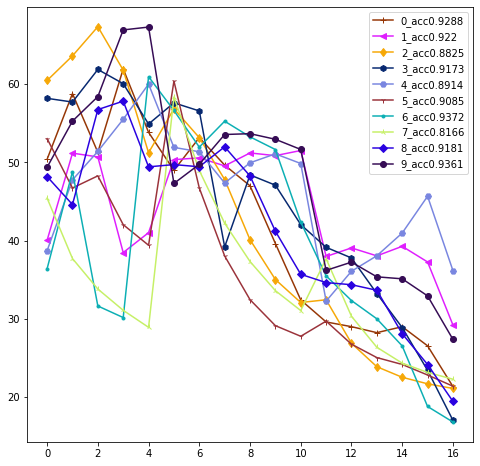

In [ ]:
plot_ids_by_layers(model_ids, (8, 8), 10)

In [8]:
import numpy as np

#Import scikitlearn for machine learning functionalities
import sklearn
from sklearn.manifold import TSNE 
from sklearn.datasets import load_digits # For the UCI ML handwritten digits dataset

# Import matplotlib for plotting graphs ans seaborn for attractive graphics.
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
%matplotlib inline

import seaborn as sb
def make_gif(frame_folder):
    frames = [Image.open(image) for image in glob(f"{frame_folder}/*.png")]
    frame_one = frames[0]
    frame_one.save("my_awesome.gif", format="GIF", append_images=frames,
            save_all=True, duration=100, loop=0)

def plot(x, colors, num_classes=10, filename='tsne.png'):
  
    palette = np.array(sb.color_palette("hls", num_classes))  #Choosing color palette 

    # Create a scatter plot.
    f = plt.figure(figsize=(8, 8))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x[:,0], x[:,1], lw=0, s=40, c=palette[colors.astype(np.int)])
    # Add the labels for each digit.
    txts = []
    for i in range(10):
        # Position of each label.
        xtext, ytext = np.median(x[colors == i, :], axis=0)
        txt = ax.text(xtext, ytext, str(i), fontsize=24)
        txt.set_path_effects([pe.Stroke(linewidth=5, foreground="w"), pe.Normal()])
        txts.append(txt)
    plt.savefig(filename)
    return f, ax, txts

In [9]:
!pwd

/home/xihe/xinhe/hyperbox/hyperbox_app/feature_shift


/datasets/xihe/miniconda3/envs/hyperbox/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/datasets/xihe/miniconda3/envs/hyperbox/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/datasets/xihe/miniconda3/envs/hyperbox/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/datasets/xihe/miniconda3/envs/hyperbox/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/datasets/xihe/miniconda3/envs/hyperbox/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will chang

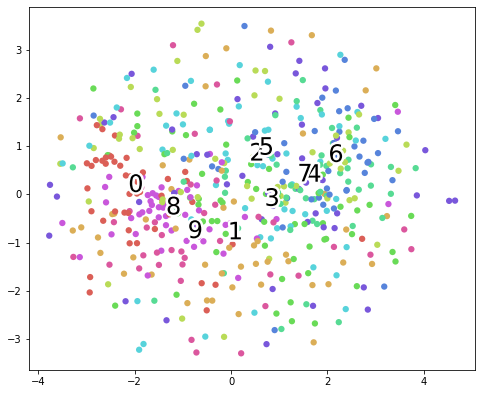

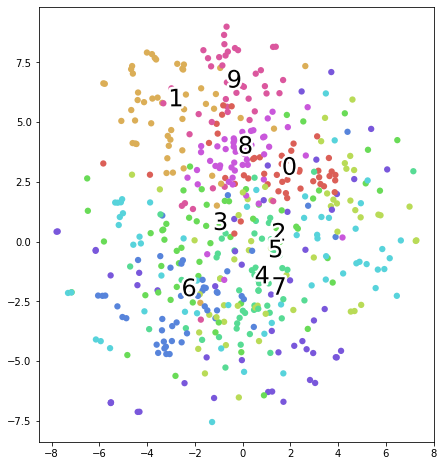

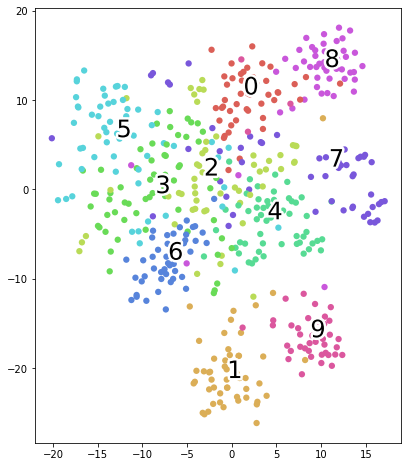

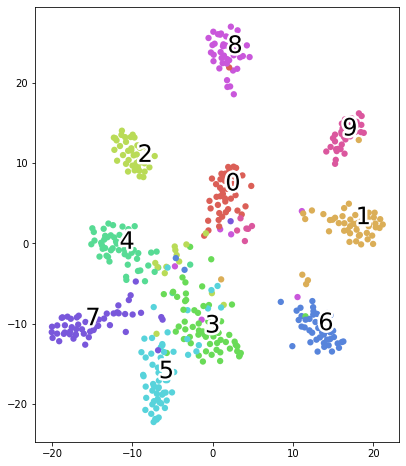

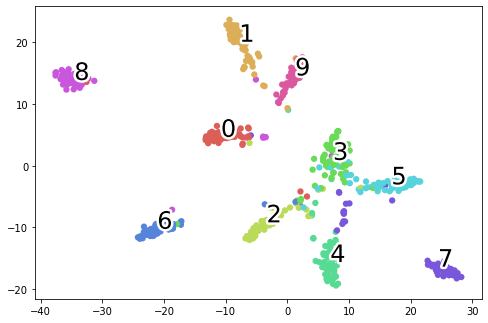

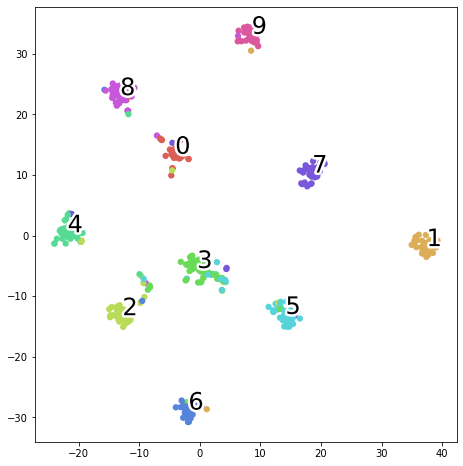

In [10]:

crt_features = features[6]
root = 'tmp_tsne'
for idx, feat in enumerate(crt_features):
    digits_final = TSNE(perplexity=30, learning_rate='auto').fit_transform(feat.detach().numpy())
    filename = os.path.join(root, f"nas201_{idx}.png")
    plot(digits_final,labels.numpy(),10)

In [11]:
make_gif(root)

IndexError: list index out of range

In [34]:
len(crt_features)

17

In [31]:
def make_gif(frame_folder, filename="my_awesome.gif"):
    frames = [Image.open(image) for image in glob(f"{frame_folder}/*.png")]
    frame_one = frames[0]
    frame_one.save(filename, format="GIF", append_images=frames,
            save_all=True, duration=1100, loop=0)

# make_gif('/home/xihe/xinhe/hyperbox/', 'nas201_feat_similarity.gif')
make_gif('/home/xihe/xinhe/hyperbox/', 'bnnas_feat_similarity.gif')